### Task

Your goal is to predict future links in a citation network. The dataset is represented by 3 files:
node_feat.txt — 32-dimensional vectors that describe the content of papers
train_edges.txt — directed edges of the citation network
unlabeled_edges.txt — unlabeled pairs of nodes
Predict labels for unlabeled pairs of nodes: 0 — disconnected, 1 — connected.

**Evaluation Criteria**


Here are balanced classes, so the usual accuracy metric is used:

Accuracy = True predictions / All predictions

Baselines:
Grade 4: Concatenate node features and train Gradient Boosting with negative sampling.
Grade 6: Train GNN with negative sampling. GNN consists of encoder and decoder. Encoder is two-layer GCN that takes node features and returns node emebeddings. Decoder is two-layer MLP that takes hadamart product of node embeddings and predicts links.

### Preparations

In [1]:
!pip install -q dgl
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
import networkx as nx
import numpy as np
import ast
import matplotlib.pyplot as plt
from torch_geometric.utils import negative_sampling
import numpy as np
import networkx as nx
import scipy as sp
import torch
from sklearn.metrics import balanced_accuracy_score
import torch.nn as nn
from tqdm.notebook import trange
from sklearn.manifold import TSNE
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import SAGEConv
from dgl.heterograph import DGLGraph
from torch_geometric.nn import GCNConv
from dgl.nn import SAGEConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [3]:
!gdown -q https://raw.githubusercontent.com/netspractice/network-science/main/datasets/lp_comp/node_feat.txt
!gdown -q https://raw.githubusercontent.com/netspractice/network-science/main/datasets/lp_comp/train_edges.txt
!gdown -q https://raw.githubusercontent.com/netspractice/network-science/main/datasets/lp_comp/unlabeled_edges.txt

### Take data

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/HSE/HSE 2 sem/Network Science/Competition2_LinkPrediction/'
path = ''
with open(f'{path}node_feat.txt') as node_feat_file:
    node_features = []
    for line in node_feat_file:
        node_features.append(list(map(float, line.split())))
    
    node_feat = torch.Tensor(node_features)

with open(f'{path}train_edges.txt') as train_edges_file:
    edges = []
    for line in train_edges_file:
        edges.append(tuple(map(int, line.split())))

with open(f'{path}unlabeled_edges.txt') as unlabeled_edges_file:
    unlabeled_edges = []
    for line in unlabeled_edges_file:
        unlabeled_edges.append(list(map(int, line.split())))
    unlabeled_edges = np.array(unlabeled_edges)

### DGL

In [ ]:
def take_edge_index(g):
  return torch.FloatTensor([sd.numpy() for sd in g.edges()]).int()

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/HSE/HSE 2 sem/Network Science/Competition2_LinkPrediction/'
path = ''
with open(f'{path}node_feat.txt') as node_feat_file:
    node_features = []
    for line in node_feat_file:
        node_features.append(list(map(float, line.split())))
    
    node_feat = torch.Tensor(node_features)

with open(f'{path}train_edges.txt') as train_edges_file:
    edges = []
    for line in train_edges_file:
        edges.append(list(map(int, line.split())))

with open(f'{path}unlabeled_edges.txt') as unlabeled_edges_file:
    unlabeled_edges = []
    for line in unlabeled_edges_file:
        unlabeled_edges.append(list(map(int, line.split())))
    unlabeled_edges = np.array(unlabeled_edges)

In [ ]:
u,v = np.array(edges).T
g = dgl.graph((u, v), num_nodes = len(node_feat))
g.ndata['feat'] = node_feat
#[src, dest]
edge_index = torch.FloatTensor([sd.numpy() for sd in g.edges()]).int()
print(g)
assert len(node_feat)==g.num_nodes()
assert len(edges)==g.num_edges()

Graph(num_nodes=12588, num_edges=14322,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.2)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]



# Find all negative edges and split them for training and testing
from torch_geometric.utils import negative_sampling
#делаем граф со всеми возможными ребрами, что бы в негативных небыло неописанных при обучении
u_unlabled, v_unlabled = np.array(unlabeled_edges).T
g_with_unlabled = dgl.graph((np.concatenate((u_unlabled, u)), np.concatenate((v_unlabled, v))), num_nodes = len(node_feat))

neg_u, neg_v = negative_sampling(take_edge_index_from_graph(g_with_unlabled), num_nodes=g_with_unlabled.num_nodes(), num_neg_samples=int(0.5*len(g.edges()[0])))
test_neg_u, test_neg_v = neg_u[:test_size], neg_v[:test_size]
train_neg_u, train_neg_v = neg_u[test_size:], neg_v[test_size:]

In [ ]:
# create train graph
train_g = dgl.remove_edges(g, eids[:test_size])
train_g.edata['label'] = torch.ones(len(train_g.edges()[0]))
train_g.add_edges(train_neg_u, train_neg_v, {'label': torch.zeros(len(train_neg_v))})

test_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_g.edata['label'] = torch.ones(len(test_g.edges()[0]))
test_g.add_edges(test_neg_u, test_neg_v, {'label': torch.zeros(len(test_neg_v))})

#### encoder,decoder, opt(enc,dec)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, h_feats)
        self.conv2 = GCNConv(h_feats, out_feats)

    def forward(self, edge_index, in_feat):
        h = self.conv1(in_feat.clone().float(), edge_index)
        h = F.relu(h)
        out_feat = self.conv2(h, edge_index)
        return out_feat

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
class LinkPredictionModel(nn.Module):
    def __init__(self, e_in_feats, e_h_feats, e_out_feats):
        super().__init__()
        self.encoder = Encoder(e_in_feats, e_h_feats, e_out_feats)
        self.decoder = DotPredictor()

    def forward(self, baseG_edges_index, in_feat, pred_graph):
        embeding = self.encoder(baseG_edges_index, in_feat)
        pred_labels = self.decoder(pred_graph, embeding)
        return pred_labels

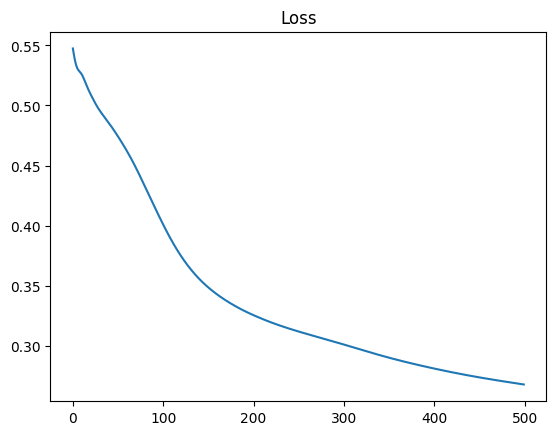

In [ ]:
model = Encoder(g.ndata['feat'].shape[1], 32, 16)
pred = DotPredictor()
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)

train_labels = train_g.edata['label']
model_edges_index = take_edge_index(dgl.remove_edges(g, eids[:test_size]))
log=[]
for e in range(500):
    # forward
    h = model(model_edges_index, train_g.ndata['feat'])
    scores = pred(train_g, h)
    loss = F.binary_cross_entropy_with_logits(scores, train_labels)
    log.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 10 == 0 and False:
        print('In epoch {}, loss: {}'.format(e, loss))
        
plt.plot(np.array(log))
plt.title('Loss')
plt.show()

In [ ]:
test_labels = test_g.edata['label']
train_labels = train_g.edata['label']
# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    test_scores = pred(test_g, h)
    print('AUC', roc_auc_score(test_labels, test_scores))
    
with torch.no_grad():
    train_score = pred(train_g, h)
    print('AUC', roc_auc_score(train_labels, train_score))

AUC 0.809312067936394
AUC 0.9695405360403384


#### Encoder2GCNConv+MLP2Lin

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, h_feats)
        self.conv2 = GCNConv(h_feats, out_feats)

    def forward(self, edge_index, in_feat):
        h = self.conv1(in_feat.clone().float(), edge_index)
        h = F.relu(h)
        out_feat = self.conv2(h, edge_index)
        return out_feat

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
# Define the MLP decoder
class MLPDecoder(torch.nn.Module):
    def __init__(self, in_channels,hidden_channels):
        super(MLPDecoder, self).__init__()

        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, pred_g, h):
        with pred_g.local_scope():
            pred_g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a hadamart product
            pred_g.apply_edges(fn.u_mul_v('h', 'h', 'score'))
            edges_feat = pred_g.edata['score']

        z = self.lin1(edges_feat)
        z = F.relu(z)
        pred = self.lin2(z)
        return pred[:,0]

In [ ]:
model = Encoder(g.ndata['feat'].shape[1], 64, 16)
pred = DotPredictor()
#pred = MLPDecoder(32, 16)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


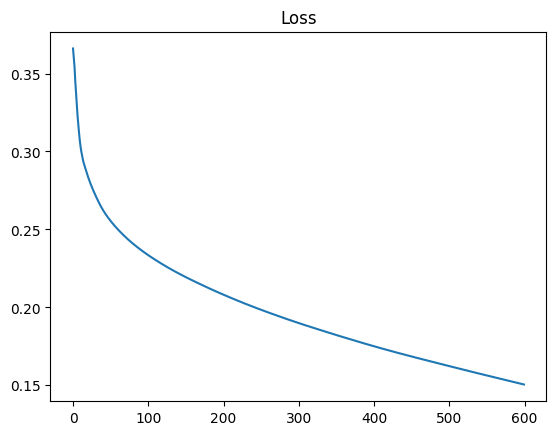

In [ ]:
train_labels = train_g.edata['label']
baseG_edges_index = take_edge_index(dgl.remove_edges(g, eids[:test_size]))
log=[]
for e in range(600):
    # forward
    h = model(baseG_edges_index, train_g.ndata['feat'])
    scores = pred(train_g, h)
    loss = F.binary_cross_entropy_with_logits(scores, train_labels)
    log.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 10 == 0 and False:
        print('In epoch {}, loss: {}'.format(e, loss))
        
plt.plot(np.array(log))
plt.title('Loss')
plt.show()

In [ ]:
test_labels = test_g.edata['label']
train_labels = train_g.edata['label']
# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    test_scores = pred(test_g, h)
    print('AUC', roc_auc_score(test_labels, test_scores))
    
with torch.no_grad():
    train_score = pred(train_g, h)
    print('AUC', roc_auc_score(train_labels, train_score))

AUC 0.743092224610655
AUC 0.9956139761152966


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [ ]:
test_labels = test_g.edata['label']
train_labels = train_g.edata['label']
# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    h =  model(take_edge_index(g), train_g.ndata['feat'])
    test_scores = pred(test_g, h)
    print('AUC', roc_auc_score(test_labels, test_scores))
    
with torch.no_grad():
    h =  model(take_edge_index(g), train_g.ndata['feat'])
    train_score = pred(train_g, h)
    print('AUC', roc_auc_score(train_labels, train_score))

AUC 0.9631902289254394
AUC 0.9791220888153894


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


После того как мы обучили подель енкодера и декодра
Мы получаем эмбендинг от всего начального графа. И в декодер закидываем граф с unlabeled связями и этим ембендингом

In [ ]:
g_unlabeled = DGLGraph()
g_unlabeled.add_nodes(len(node_feat))
g_unlabeled.add_edges(u_unlabled, v_unlabled)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
with torch.no_grad():
    h_unlabeled = model(take_edge_index(g), g.ndata['feat'])
    score = pred(g_unlabeled, h_unlabeled)
    score[score>=0.5]=1
    score[score<0.5]=0
assert len(score)==len(unlabeled_edges)
with open('output1.txt', 'w') as output_file:
    for i in score:
        output_file.write(str(i.int().item())+'\n')

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [ ]:
assert (unlabeled_edges.T[0] == g_unlabeled.edges()[0].numpy()).all()

###ChatGptVersion

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x.float(), edge_index))
        x = self.conv2(x, edge_index)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, 32)
        self.fc2 = nn.Linear(32, out_channels)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__()
        self.encoder = Encoder(in_channels, out_channels)
        self.decoder = Decoder(out_channels, 1)
    def forward(self, x, pos_edge_index, neg_edge_index):
        pos_embed = self.encoder(x, pos_edge_index)
        neg_embed = self.encoder(x, neg_edge_index)
        pos_score = self.decoder(pos_embed)
        return pos_score, neg_score
# Load data
node_features = torch.from_numpy(np.loadtxt(f'{path}node_feat.txt'))
train_edges = torch.from_numpy(np.loadtxt(f'{path}train_edges.txt', dtype=int).T)
unlabeled_edges = torch.from_numpy(np.loadtxt(f'{path}unlabeled_edges.txt', dtype=int).T)
# Define model, optimizer, and loss function
model = GNN(node_features.shape[1], 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
# Train model
log=[]
for epoch in range(500):
    pos_edge_index = train_edges
    neg_edge_index = negative_sampling(train_edges, num_nodes=node_features.shape[0])
    optimizer.zero_grad()
    pos_score, neg_score = model(node_features, pos_edge_index, neg_edge_index)
    y = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    y_pred = torch.cat([pos_score, neg_score])
    #loss = criterion(y_pred.reshape(-1), y)
    loss = F.cross_entropy(y_pred.reshape(-1), y)
    loss.backward()
    optimizer.step()
    # Evaluate model
    with torch.no_grad():
        val_loss = F.cross_entropy(y_pred.reshape(-1), y)
    log.append([loss.item()])

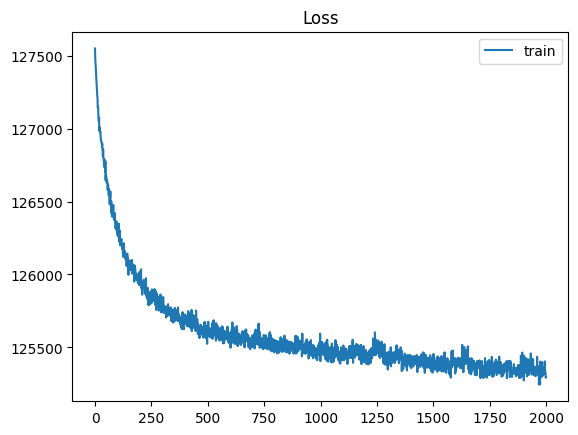

In [ ]:
plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

### DGL Example. GraphSAGE + Dotpredictor (0.751)

https://docs.dgl.ai/en/0.8.x/tutorials/blitz/4_link_predict.html

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
g = DGLGraph()
g.add_nodes(len(node_feat))
g.ndata['feat'] = torch.Tensor(node_feat)
u,v = np.array(edges).T
g.add_edges(u, v)
print(g)
assert len(node_feat)==g.num_nodes()
assert len(edges)==g.num_edges()

Graph(num_nodes=12588, num_edges=14322,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
n = max(max(u), max(v)) + 1
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(n, n))

#adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

train_g = dgl.remove_edges(g, eids[:test_size])

In [ ]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, out_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        #h = F.relu(h)
        #h = self.conv2(g, h)
        return h

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super().__init__()
        self.conv1 = GCNConv(in_feats, h_feats, 'mean')
        self.conv2 = GCNConv(h_feats, out_feats, 'mean')

    def forward(self, g, in_feat):
        u1, v1 = g.edges()
        edge_index = torch.FloatTensor([u1.numpy(), v1.numpy()]).int()
        feat_1 = self.conv1(in_feat.clone().float(), edge_index)
        feat_r = F.relu(feat_1)
        feat_2 = self.conv2(feat_r, edge_index)
        return feat_2
        return feat_2

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
# Define the MLP decoder
class MLPDecoder(torch.nn.Module):
    def __init__(self, in_channels,hidden_channels):
        super(MLPDecoder, self).__init__()

        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, pred_g, h):
        with pred_g.local_scope():
            pred_g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a hadamart product
            pred_g.apply_edges(fn.u_mul_v('h', 'h', 'score'))
            edges_feat = pred_g.edata['score']

        z = self.lin1(edges_feat)
        z = F.relu(z)
        pred = self.lin2(z)
        return pred[:,0]

In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 64, 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()
pred = MLPDecoder(16,32)

# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(600):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))
    
with torch.no_grad():
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 0.6926841139793396
In epoch 5, loss: 0.6879785060882568
In epoch 10, loss: 0.6830762028694153
In epoch 15, loss: 0.6788231134414673
In epoch 20, loss: 0.6734856963157654
In epoch 25, loss: 0.6658949255943298
In epoch 30, loss: 0.6563845276832581
In epoch 35, loss: 0.6446473002433777
In epoch 40, loss: 0.6312447190284729
In epoch 45, loss: 0.6180336475372314
In epoch 50, loss: 0.6072433590888977
In epoch 55, loss: 0.5979774594306946
In epoch 60, loss: 0.5888267755508423
In epoch 65, loss: 0.5801183581352234
In epoch 70, loss: 0.5696356296539307
In epoch 75, loss: 0.5567657351493835
In epoch 80, loss: 0.5430266857147217
In epoch 85, loss: 0.5292423367500305
In epoch 90, loss: 0.5163413882255554
In epoch 95, loss: 0.5043857097625732
In epoch 100, loss: 0.49308452010154724
In epoch 105, loss: 0.48094063997268677
In epoch 110, loss: 0.46776503324508667
In epoch 115, loss: 0.45335888862609863
In epoch 120, loss: 0.438006192445755
In epoch 125, loss: 0.4246279299259186
In ep

In [ ]:
g_unlabeled = DGLGraph()
g_unlabeled.add_nodes(len(node_feat))
g_unlabeled.ndata['feat'] = node_feat
u,v = np.array(unlabeled_edges).T
g_unlabeled.add_edges(u, v)
print(g_unlabeled)
assert len(node_feat)==g_unlabeled.num_nodes()
assert len(unlabeled_edges)==g_unlabeled.num_edges()

Graph(num_nodes=12588, num_edges=44014,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
with torch.no_grad():
    h_unlabeled = model(g_unlabeled, g_unlabeled.ndata['feat'])
    score = pred(g_unlabeled, h)
    score[score>=0.5]=1
    score[score<0.5]=0
assert len(score)==len(unlabeled_edges)

AssertionError: ignored

In [ ]:
#0.71
with torch.no_grad():
    h_unlabeled = model(g_with_unlabled, node_feat)
    score = pred(g_unlabeled, h)
    score[score>=0.5]=1
    score[score<0.5]=0
assert len(score)==len(unlabeled_edges)

In [ ]:
len(score)

In [ ]:
with open('output1.txt', 'w') as output_file:
    for i in score:
        output_file.write(str(i.int().item())+'\n')

### GradientBoosting(notMy)

#### Work wit data

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/HSE/HSE 2 sem/Network Science/Competition2_LinkPrediction/'
path=''
with open(f'{path}node_feat.txt') as node_feat_file:
    node_features = []
    for line in node_feat_file:
        node_features.append(list(map(float, line.split())))
    
    node_feat = torch.Tensor(node_features)

with open(f'{path}train_edges.txt') as train_edges_file:
    edges = []
    for line in train_edges_file:
        edges.append(tuple(map(int, line.split())))

with open(f'{path}unlabeled_edges.txt') as unlabeled_edges_file:
    unlabeled_edges = []
    for line in unlabeled_edges_file:
        unlabeled_edges.append(list(map(int, line.split())))
    unlabeled_edges = np.array(unlabeled_edges)

In [ ]:
assert len(node_features[0])==32

In [ ]:
eids = np.arange(len(edges))
eids = np.random.permutation(eids)
test_size = int(len(edges) * 0.1)

test_pos = []
train_pos = []
for i in eids[:test_size]:
    test_pos.append(edges[i])

for i in eids[test_size:]:
    train_pos.append(edges[i])

In [ ]:
def negative_sampling2(train_pos, test_pos, unlabled_edges):
    pos_edges = train_pos + test_pos
    nodes = np.unique(pos_edges)
    print(len(nodes))
    #pos_edges += unlabled_edges #delete
    neg_edges = []
    for u, v in pos_edges:
        while True:
            neg_v = np.random.choice(nodes)
            if (u == neg_v) or ((u, neg_v) in pos_edges) or ((neg_v, u) in pos_edges):
                continue
            neg_edges.append((u, neg_v))
            break
    return neg_edges[:len(train_pos)], neg_edges[len(train_pos):]

In [ ]:
with open(f'{path}unlabeled_edges.txt') as unlabeled_edges_file:
    unlabeled_edges_set = []
    for line in unlabeled_edges_file:
        unlabeled_edges_set.append(set(map(int, line.split())))

train_neg, test_neg = negative_sampling2(train_pos, test_pos, unlabeled_edges_set)
neg_edges = train_neg + test_neg
pos_edges = train_pos + test_pos

12588


In [ ]:
x_train = np.random.permutation(train_pos + train_neg)
y_train = [int((u, v) in train_pos) for (u, v) in x_train]

x_test = np.random.permutation(test_pos + test_neg)
y_test = [int((u, v) in test_pos) for (u, v) in x_test]

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

25780
25780
2864
2864


#### Variants of edge embending

In [ ]:
#0.74
def hadamard_operator(G, embeddings, edges):
    #nodes_embeddings = np.array(embeddings.clone())
    nodes_embeddings = embeddings.clone().detach().numpy()
    edges_embeddings = []
    for u, v in edges:
        uv_edge_emb = nodes_embeddings[u] * nodes_embeddings[v]
        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

In [ ]:
#0.73
def neighbor_weighted_l1_operator(G, embeddings, edges):
    G_copy = nx.Graph(G)
    nodes_embeddings = np.array(embeddings.clone())
    edges_embeddings = []
    for u, v in edges:
        try:
          u_neigb = list(G_copy.neighbors(u))
        except:
          u_neigb = []
        try:
          v_neigb = list(G_copy.neighbors(v))
        except:
          v_neigb = []
        ind_for_sum_u = u_neigb + [u]
        ind_for_sum_v = v_neigb + [v]

        fu = nodes_embeddings[ind_for_sum_u].sum(axis=0) / len(ind_for_sum_u)
        fv = nodes_embeddings[ind_for_sum_v].sum(axis=0) / len(ind_for_sum_v)

        uv_edge_emb = abs(fu + fv)

        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

In [ ]:
#0.77
def concatinate(G, embeddings, edges):
    #nodes_embeddings = np.array(embeddings.clone())
    nodes_embeddings = embeddings.clone().detach().numpy()
    edges_embeddings = []
    for u, v in edges:
        uv_edge_emb = np.concatenate((nodes_embeddings[u],nodes_embeddings[v]), axis=0)
        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

#### Train

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
function = concatinate
G = nx.DiGraph()
G.add_edges_from(train_pos)
train_emb =  function(G, node_feat, x_train)
test_emb = function(G, node_feat, x_test)
unl_emb = function(G, node_feat, unlabeled_edges)

In [ ]:
import lightgbm as lgb

train_dataset = lgb.Dataset(train_emb, y_train)
test_dataset = lgb.Dataset(test_emb, y_test)

params = {'learning_rate': 0.01, 'max_depth': 15, "objective": "binary", "verbosity": -1}

booster = lgb.train(params,
                    train_set=train_dataset, valid_sets=(test_dataset),
                    num_boost_round=2500)

In [ ]:
train_preds = booster.predict(train_emb)
test_preds = booster.predict(test_emb)

In [ ]:
train_preds_bin = [1 if pred > 0.5 else 0 for pred in train_preds]
test_preds_bin = [1 if pred > 0.5 else 0 for pred in test_preds]

print("Test Accuracy: %.3f"%accuracy_score(y_test, test_preds_bin))
print("Train Accuracy: %.3f"%accuracy_score(y_train, train_preds_bin))

Test Accuracy: 0.922
Train Accuracy: 0.978


In [ ]:
y_pred_unl = booster.predict(unl_emb)
y_pred_unl = [1 if pred > 0.5 else 0 for pred in y_pred_unl]
y_pred_unl = np.array(y_pred_unl, dtype=int)
with open('output1.txt', 'w') as output_file:
    for i in y_pred_unl:
        output_file.write(str(i)+'\n')

### My

#### take data

In [9]:
def take_edge_index_from_graph(g):
  return torch.FloatTensor(np.array([sd.numpy() for sd in g.edges()])).int()

#take origin data
path=''
with open(f'{path}node_feat.txt') as node_feat_file:
    node_features = []
    for line in node_feat_file:
        node_features.append(list(map(float, line.split())))
    #node_feat = torch.Tensor(node_features)
    node_feat = np.array(node_features)

with open(f'{path}train_edges.txt') as train_edges_file:
    edges = []
    for line in train_edges_file:
        edges.append(list(map(int, line.split())))
    edges = np.array(edges)

with open(f'{path}unlabeled_edges.txt') as unlabeled_edges_file:
    unlabeled_edges = []
    for line in unlabeled_edges_file:
        unlabeled_edges.append(list(map(int, line.split())))
    unlabeled_edges = np.array(unlabeled_edges)

print(unlabeled_edges.shape, edges.shape, node_feat.shape)

(44014, 2) (14322, 2) (12588, 32)


In [10]:
u,v = edges.T
g = dgl.graph((u,v), num_nodes = len(node_feat))
g.ndata['feat'] = torch.Tensor(node_feat)
print(g)
assert len(node_feat)==g.num_nodes()
assert len(edges)==g.num_edges()

Graph(num_nodes=12588, num_edges=14322,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [11]:
u_unlabled, v_unlabled = unlabeled_edges.T
assert np.concatenate((u_unlabled, u)).shape[0] == len(unlabeled_edges)+len(edges)
u_all = np.concatenate((u_unlabled, u))
v_all = np.concatenate((v_unlabled, v))
g_with_unlabled = dgl.graph((u_all, v_all), num_nodes = len(node_feat))
g_with_unlabled.ndata['feat'] = torch.Tensor(node_feat)
g_with_unlabled

Graph(num_nodes=12588, num_edges=58336,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})

In [15]:
#####
test_persent = 0.2
#####

# делим существующик эйджи на трейн и тест
def test_train_edges(edges, test_persent=0.2):
    edges = torch.Tensor(edges).int()
    e_ids = np.arange(len(edges))
    e_ids = np.random.permutation(e_ids)

    test_size = int(len(e_ids) * test_persent)
    train_size = g.number_of_edges() - test_size

    edges_test = edges[e_ids[:test_size]]
    edges_train = edges[e_ids[test_size:]]
    return edges_test, edges_train

edges_pos_test, edges_pos_train = test_train_edges(edges, test_persent=test_persent)

In [16]:
#получить негативные эйджи
#на вход граф и получаем несуществующие эйджи
from torch_geometric.utils import negative_sampling

def negative_edges_from_graph(g, size):
    edge_index = take_edge_index_from_graph(g)
    negative_sampling(edge_index, num_nodes=g.num_nodes(), num_neg_samples=size)
    return negative_sampling(edge_index, num_nodes=g.num_nodes(), num_neg_samples=size).T

#два варианта либо учитывать андлебл или нет
if True:
    print('Учитываем эйджи unlabled')
    edges_neg = negative_edges_from_graph(g_with_unlabled, size=len(edges))
else:
    print('Учитываем эйджи только помеченные')
    edges_neg = negative_edges_from_graph(g, size=len())

#делим на тест и трейн
edges_neg_test, edges_neg_train = test_train_edges(edges_neg, test_persent=test_persent)

Учитываем эйджи unlabled


#### edges embendings functions

In [17]:
def hadamard_operator(G, embeddings, edges):
    nodes_embeddings = embeddings.copy()
    #nodes_embeddings = embeddings.clone().detach().numpy()
    edges_embeddings = []
    for u, v in edges:
        uv_edge_emb = nodes_embeddings[u] * nodes_embeddings[v]
        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

In [18]:
def substract(G, embeddings, edges):
    nodes_embeddings = embeddings.copy()
    #nodes_embeddings = embeddings.clone().detach().numpy()
    edges_embeddings = []
    for u, v in edges:
        uv_edge_emb = nodes_embeddings[v] - nodes_embeddings[u] 
        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

In [31]:
def neighbor_weighted_l1_operator(G, embeddings, edges):
    G_copy = nx.Graph(G)
    nodes_embeddings = np.array(embeddings.copy())
    edges_embeddings = []
    for u, v in edges:
        try:
          u_neigb = list(G_copy.neighbors(u))
        except:
          u_neigb = []
        try:
          v_neigb = list(G_copy.neighbors(v))
        except:
          v_neigb = []
        ind_for_sum_u = u_neigb + [u]
        ind_for_sum_v = v_neigb + [v]

        fu = nodes_embeddings[ind_for_sum_u].sum(axis=0) / len(ind_for_sum_u)
        fv = nodes_embeddings[ind_for_sum_v].sum(axis=0) / len(ind_for_sum_v)

        uv_edge_emb = abs(fu + fv)

        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

In [20]:
def concatinate(G, embeddings, edges):
    nodes_embeddings = embeddings.copy()
    #nodes_embeddings = embeddings.clone().detach().numpy()
    edges_embeddings = []
    for u, v in edges:
        uv_edge_emb = np.concatenate((nodes_embeddings[u],nodes_embeddings[v]), axis=0)
        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def concatinate_with_cosine(G, embeddings, edges):
    nodes_embeddings = embeddings.copy()
    #nodes_embeddings = embeddings.clone().detach().numpy()
    edges_embeddings = []
    for u, v in edges:
        c_sim = cosine_similarity(nodes_embeddings[u].reshape(1, -1), nodes_embeddings[v].reshape(1, -1))[0]
        uv_edge_emb = np.concatenate((c_sim, nodes_embeddings[u],nodes_embeddings[v]), axis=0)
        edges_embeddings.append(uv_edge_emb)
    return np.array(edges_embeddings)

#### take embendings

In [22]:
#prepare data X and 
#train
x_train = torch.cat((edges_pos_train,edges_neg_train))
y_train = torch.cat((torch.ones(len(edges_pos_train)), torch.zeros(len(edges_neg_train))))
tmp_index = np.arange(len(x_train))
tmp_index = np.random.permutation(tmp_index)

x_train = x_train[tmp_index]
y_train = y_train[tmp_index]

#test
x_test = torch.cat((edges_pos_test,edges_neg_test))
y_test = torch.cat((torch.ones(len(edges_pos_test)), torch.zeros(len(edges_neg_test))))
tmp_index = np.arange(len(x_test))
tmp_index = np.random.permutation(tmp_index)

x_test = x_test[tmp_index]
y_test = y_test[tmp_index]

In [28]:
# take embendings
#странный вариант с графом и получение эмбендинга через соседей

g_train, g_test = nx.Graph(), nx.Graph()
g_train.add_nodes_from(range(len(node_feat)))
g_test.add_nodes_from(range(len(node_feat)))


g_train.add_edges_from(x_train)

g_test.add_edges_from(edges_pos_train)
g_test.add_edges_from(edges_pos_test)
g_test.add_edges_from(edges_neg_test)
emb_func = neighbor_weighted_l1_operator
train_emb =  emb_func(g_train, node_feat, x_train)
test_emb = emb_func(g_test, node_feat, x_test)

#здесь в теории можно полный граф g вставить
#unl_emb = emb_func(g_pos_train, node_feat, unlabeled_edges)

In [ ]:
# take embendings
#####
# concatinate 
# neighbor_weighted_l1_operator 
# hadamard_operator
# concatinate_with_cosine
# substract
emb_func = neighbor_weighted_l1_operator
#####
g_pos_train = nx.DiGraph()
g_pos_train.add_edges_from(edges_pos_train)

train_emb =  emb_func(g_pos_train, node_feat, x_train)
test_emb = emb_func(g_pos_train, node_feat, x_test)

#здесь в теории можно полный граф g вставить
unl_emb = emb_func(g_pos_train, node_feat, unlabeled_edges)

#### boosting models

##### lightgbm (0.764)

In [35]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_dataset = lgb.Dataset(train_emb, y_train.numpy())
test_dataset = lgb.Dataset(test_emb, y_test.numpy())

params = {'learning_rate': 0.02, 'max_depth': 17, "objective": "binary", "verbosity": -1}
# (0.779; 1) 0.05 15 3000 conc
# (0.771; 0.98) 0.05 12 1000 conc
# (0.766; 0,98) 0.01 10 5000 conc+sim
#
#
#

booster = lgb.train(params,
                    train_set=train_dataset, valid_sets=(test_dataset), verbose_eval=False,
                    num_boost_round=2500)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [37]:
from sklearn.metrics import accuracy_score

train_preds = booster.predict(train_emb)
test_preds = booster.predict(test_emb)

train_preds_bin = [1 if pred > 0.5 else 0 for pred in train_preds]
test_preds_bin = [1 if pred > 0.5 else 0 for pred in test_preds]

print("Test Accuracy: %.3f"%accuracy_score(y_test, test_preds_bin))
print("Train Accuracy: %.3f"%accuracy_score(y_train, train_preds_bin))

Test Accuracy: 0.500
Train Accuracy: 0.500


In [ ]:
grid = [[0.01, 0.025, 0.05],[10, 13, 16],[1500, 2500, 4500]]
for i in range(3):
  for j in range(3):
    for k in range(3):
      lr = grid[0][i]
      depth = grid[1][j]
      epoch = grid[2][k]
      params = {'learning_rate':lr, 'max_depth': depth, "objective": "binary", "verbosity": -1}
      booster = lgb.train(params,
                    train_set=train_dataset, valid_sets=(test_dataset), verbose_eval=False,
                    num_boost_round=epoch)

      train_preds = booster.predict(train_emb)
      test_preds = booster.predict(test_emb)

      train_preds_bin = [1 if pred > 0.5 else 0 for pred in train_preds]
      test_preds_bin = [1 if pred > 0.5 else 0 for pred in test_preds]

      print(f'{lr}, {depth}, {epoch}, {accuracy_score(y_test, test_preds_bin)}, {accuracy_score(y_train, train_preds_bin)}')

In [ ]:
y_pred_unl = booster.predict(unl_emb)
y_pred_unl = [1 if pred > 0.5 else 0 for pred in y_pred_unl]
y_pred_unl = np.array(y_pred_unl, dtype=int)
with open('0.05.16.4500.txt', 'w') as output_file:
    for i in y_pred_unl:
        output_file.write(str(i)+'\n')

###### Try add hadamart

##### XGBClassifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
xgbc = XGBClassifier(learning_rate=0.1, max_depth=10)
#xgbc = XGBClassifier()
xgbc.fit(train_emb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
print("Test Accuracy: %.3f"%accuracy_score(y_test, xgbc.predict(test_emb)))
print("Train Accuracy: %.3f"%accuracy_score(y_train, xgbc.predict(train_emb)))

Test Accuracy: 0.734
Train Accuracy: 0.970


#####  Catboost

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

In [ ]:
cat.fit(train_emb,y_train.numpy(),verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10]}
#objective
cat_grid = CatBoostRegressor()
grid_search_result = cat_grid.grid_search(grid, X=train_emb, y=y_train.numpy())

In [ ]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.05}

In [ ]:
cat = CatBoostRegressor(depth=10, learning_rate=0.02)
#10 0.05 0.74

In [ ]:
cat.fit(train_emb,y_train.numpy(),verbose=False)

In [ ]:
print("Test Accuracy: %.3f"%accuracy_score(y_test.numpy(), [1 if pred > 0.5 else 0 for pred in cat.predict(test_emb)]))
print("Train Accuracy: %.3f"%accuracy_score(y_train, [1 if pred > 0.5 else 0 for pred in cat.predict(train_emb)]))

Test Accuracy: 0.736
Train Accuracy: 0.912


#### GCN

##### encoders (feat, edges_index)

In [ ]:
from torch_geometric.nn import GCNConv as torchGCNConv
from torch_geometric.nn import GraphConv as torchGraphConv
from torch_geometric.nn import SAGEConv as torchSAGEConv
from torch_geometric.nn import SimpleConv as torchSimpleConv
from torch_geometric.nn import TransformerConv as torchTransformerConv

In [ ]:
#torch_geometric.GCNConv
# на вход фичи и edge_index норм графа
class EncoderTorch(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, conv=torchGCNConv):
        super().__init__()
        self.conv1 = conv(in_dim, hidden_dim)
        self.conv2 = conv(hidden_dim, out_dim)

    def forward(self, in_feat, edge_index):
        h = self.conv1(in_feat.clone().float(), edge_index)
        h = F.relu(h)
        out_feat = self.conv2(h, edge_index)
        return out_feat

In [ ]:
#torch_geometric.GCNConv
# на вход фичи и edge_index норм графа
class EncoderTorch(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, conv=torchGCNConv):
        super().__init__()
        self.conv1 = conv(in_dim, out_dim)
        #self.conv2 = conv(hidden_dim, out_dim)

    def forward(self, in_feat, edge_index):
        h = self.conv1(in_feat.clone().float(), edge_index)
        #h = F.relu(h)
        #out_feat = self.conv2(h, edge_index)
        return h

In [ ]:
from dgl.nn import SAGEConv as dglSAGEConv
from dgl.nn import GraphConv as dglGraphConv

In [ ]:
#DGL
# фичи и edge_index норм графа, но внутри делаем сам граф для SAGEConv
class EncoderDgl(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, conv=dglGraphConv):
        super().__init__()
        self.conv1 = conv(in_dim, hidden_dim)
        self.conv2 = conv(hidden_dim, out_dim)

    def forward(self, in_feat, edge_index):
        g = dgl.graph((edge_index[0],edge_index[1]), num_nodes = len(in_feat))
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        out_feat = self.conv2(g, h)
        return out_feat

##### decoders (graph_pred, feat)

In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()

    def forward(self, h, g):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
class MLPDecoderMul(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()

        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, h, pred_g):
        with pred_g.local_scope():
            pred_g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a hadamart product
            pred_g.apply_edges(fn.u_mul_v('h', 'h', 'score'))
            edges_feat = pred_g.edata['score']

        z = self.lin1(edges_feat)
        z = F.relu(z)
        pred = self.lin2(z)
        return pred[:,0]

In [ ]:
def had_operator(embeddings, edge_index):
    edges_embeddings = embeddings[edge_index[0]] * embeddings[edge_index[1]]
    return edges_embeddings
    
def cat_operator(embeddings, edge_index):
    edges_embeddings = torch.cat((embeddings[edge_index[0]], embeddings[edge_index[1]]), dim=1)
    return edges_embeddings

class MLPDecoderHad(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()

        self.lin1 = torch.nn.Linear(in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, h, pred_g):
        with pred_g.local_scope():
            h = had_operator(h, take_edge_index_from_graph(pred_g))
            pred_g.edata['score'] = h
            edges_feat = pred_g.edata['score']

        z = self.lin1(edges_feat)
        z = F.relu(z)
        pred = self.lin2(z)
        return pred[:,0]

class MLPDecoderCat(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()

        self.lin1 = torch.nn.Linear(2*in_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, h, pred_g):
        with pred_g.local_scope():
            h = cat_operator(h, take_edge_index_from_graph(pred_g))
            pred_g.edata['score'] = h
            edges_feat = pred_g.edata['score']

        z = self.lin1(edges_feat)
        z = F.relu(z)
        pred = self.lin2(z)
        return pred[:,0]

##### model

In [ ]:
class PredictionModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, hidden_dim2, encoder=EncoderTorch, decoder=DotPredictor, enc_conv=torchGCNConv):
        super().__init__()
        self.enc = encoder(in_dim, hidden_dim, out_dim, conv = enc_conv)
        self.dec = decoder(out_dim, hidden_dim2)

    def forward(self, baseG_edges_index, in_feat, pred_graph):
        embeding = self.enc(in_feat, baseG_edges_index)
        pred_labels = self.dec(embeding, pred_graph)
        return pred_labels

##### data for train

In [ ]:
#take origin data
path=''
with open(f'{path}node_feat.txt') as node_feat_file:
    node_features = []
    for line in node_feat_file:
        node_features.append(list(map(float, line.split())))
    #node_feat = torch.Tensor(node_features)
    node_feat = np.array(node_features)

with open(f'{path}train_edges.txt') as train_edges_file:
    edges = []
    for line in train_edges_file:
        edges.append(list(map(int, line.split())))
    edges = np.array(edges)

with open(f'{path}unlabeled_edges.txt') as unlabeled_edges_file:
    unlabeled_edges = []
    for line in unlabeled_edges_file:
        unlabeled_edges.append(list(map(int, line.split())))
    unlabeled_edges = np.array(unlabeled_edges)

print(unlabeled_edges.shape, edges.shape, node_feat.shape)

(44014, 2) (14322, 2) (12588, 32)


In [ ]:
def take_edge_index_from_graph(g):
  return torch.FloatTensor(np.array([sd.numpy() for sd in g.edges()])).int()

In [ ]:
u,v = edges.T
g = dgl.graph((u,v), num_nodes = len(node_feat))
g.ndata['feat'] = torch.Tensor(node_feat)
print(g)
assert len(node_feat)==g.num_nodes()
assert len(edges)==g.num_edges()

Graph(num_nodes=12588, num_edges=14322,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
u_unlabled, v_unlabled = unlabeled_edges.T
assert np.concatenate((u_unlabled, u)).shape[0] == len(unlabeled_edges)+len(edges)
u_all = np.concatenate((u_unlabled, u))
v_all = np.concatenate((v_unlabled, v))
g_with_unlabled = dgl.graph((u_all, v_all), num_nodes = len(node_feat))
g_with_unlabled.ndata['feat'] = torch.Tensor(node_feat)
g_with_unlabled

Graph(num_nodes=12588, num_edges=58336,
      ndata_schemes={'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
# basegraph - из ткоторого получаем эмбендинги
# train graph - эйджи которые нужно предсказать
# test graph - эйджи которые нужно предсказать только тестовые
#####
test_persent = 0.15
train_persent = 0.15
#####

def test_train_edges(edges, train_persent=0.15, test_persent=0.15):
    edges = torch.Tensor(edges).int()
    e_ids = np.arange(len(edges))
    e_ids = np.random.permutation(eids)

    test_size = int(len(e_ids) * test_persent)
    train_size = int(len(e_ids) * train_persent)

    edges_test = edges[e_ids[:test_size]]
    edges_train = edges[e_ids[test_size:test_size+train_size]]
    e_ids_for_delete = e_ids[:test_size+train_size]
    return edges_test, edges_train, e_ids_for_delete

In [ ]:
#получить негативные эйджи
#на вход граф и получаем несуществующие эйджи
from torch_geometric.utils import negative_sampling

def negative_edges_from_graph(g, size):
    edge_index = take_edge_index_from_graph(g)
    negative_sampling(edge_index, num_nodes=g.num_nodes(), num_neg_samples=size)
    return negative_sampling(edge_index, num_nodes=g.num_nodes(), num_neg_samples=size).T

#два варианта либо учитывать андлебл или нет
if True:
    print('Учитываем эйджи unlabled')
    edges_neg = negative_edges_from_graph(g_with_unlabled, size=len(edges))
else:
    print('Учитываем эйджи только помеченные')
    edges_neg = negative_edges_from_graph(g, size=len())

Учитываем эйджи unlabled


In [ ]:
#делим на тест и трейн
edges_pos_test, edges_pos_train, e_ids_for_delete = test_train_edges(edges, train_persent=0.2, test_persent=0.10)
edges_neg_test, edges_neg_train, _ = test_train_edges(edges_neg, train_persent=0.2, test_persent=0.10)
assert len(edges_neg_test)==len(edges_pos_test)

NameError: ignored

In [ ]:
# не перемешанные
# create graphs for training
#base_g for get emb
base_g = dgl.remove_edges(g, e_ids_for_delete)

#train_g for predict
train_g = dgl.graph((edges_pos_train.T[0],edges_pos_train.T[1]), num_nodes = len(node_feat))
train_g.edata['label'] = torch.ones(len(edges_pos_train))
train_g.add_edges(edges_neg_train.T[0], edges_neg_train.T[1], {'label': torch.zeros(len(edges_neg_train))})

#test_g for predict
test_g = dgl.graph((edges_pos_test.T[0],edges_pos_test.T[1]), num_nodes = len(node_feat))
test_g.edata['label'] = torch.ones(len(edges_pos_test))
test_g.add_edges(edges_neg_test.T[0], edges_neg_test.T[1], {'label': torch.zeros(len(edges_neg_test))})

In [ ]:
base_g = dgl.remove_edges(g, e_ids_for_delete)

# перемешанные
#train_g for predict
labels_train = torch.cat((torch.ones(len(edges_pos_train)),torch.zeros(len(edges_neg_train))))
edges_train = torch.cat((edges_pos_train, edges_neg_train))
tmp_idxs = np.arange(len(edges_train))
tmp_idxs = np.random.permutation(tmp_idxs)
labels_train = labels_train[tmp_idxs]
edges_train = edges_train[tmp_idxs]
train_g = DGLGraph()
train_g.add_nodes(len(node_feat[0]))
train_g.add_edges(edges_train.T[0].long(), edges_train.T[1].long(), {'label': labels_train})

#test_g for predict
labels_test = torch.cat((torch.ones(len(edges_pos_test)),torch.zeros(len(edges_neg_test))))
edges_test = torch.cat((edges_pos_test, edges_neg_test))
tmp_idxs = np.arange(len(edges_test))
tmp_idxs = np.random.permutation(tmp_idxs)
labels_test = labels_test[tmp_idxs]
edges_test = edges_test[tmp_idxs]
test_g = DGLGraph()
test_g.add_nodes(len(node_feat[0]))
test_g.add_edges(edges_test.T[0].long(), edges_test.T[1].long(), {'label': labels_test})

##### initialisation

In [ ]:
#ENC_CONV_TORCH: torchGCNConv, torchGraphConv, torchSAGEConv, torchTransformerConv
#ENC_CONV_DGL: dglSAGEConv, dglGraphConv
#ENCODERS EncoderTorch, EncoderDgl
#DECODER: DotPredoctor, MLPDecoderHad
model = PredictionModel(node_feat.shape[1], 
                        hidden_dim = 32, 
                        out_dim = 32, 
                        hidden_dim2 = 16,
                        encoder = EncoderTorch,
                        decoder = MLPDecoderHad,
                        enc_conv= torchGCNConv)
model

PredictionModel(
  (enc): EncoderTorch(
    (conv1): GCNConv(32, 32)
  )
  (dec): MLPDecoderHad(
    (lin1): Linear(in_features=32, out_features=16, bias=True)
    (lin2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters()), lr=0.001)

##### train

In [ ]:
train_labels = train_g.edata['label']
log=[]


for e in range(1000):
    # forward
    scores = model(take_edge_index_from_graph(base_g).long(), g.ndata['feat'].float(), train_g)
    loss = F.binary_cross_entropy_with_logits(scores, train_labels)
    log.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 10 == 0 and False:
        print('In epoch {}, loss: {}'.format(e, loss))
        
plt.plot(np.array(log))
plt.title('Loss')
plt.show()

In [ ]:
test_labels = test_g.edata['label']
train_labels = train_g.edata['label']
# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    test_scores = model(take_edge_index_from_graph(base_g).long(), g.ndata['feat'].float(), test_g)
    test_pred_labels = [1 if pred > 0 else 0 for pred in test_scores]
    print('Accuracy_score', accuracy_score(test_labels, test_pred_labels),'AUC', roc_auc_score(test_labels, test_scores))
    
with torch.no_grad():
    train_score = model(take_edge_index_from_graph(base_g).long(), g.ndata['feat'].float(), train_g)
    train_pred_labels = [1 if pred > 0 else 0 for pred in train_score]
    print('Accuracy_score', accuracy_score(train_labels, train_pred_labels),'AUC', roc_auc_score(train_labels, train_score))

NameError: ignored

##### Out

In [ ]:
with torch.no_grad():
    g_unlabeled = dgl.graph((u_unlabled, v_unlabled), num_nodes = len(node_feat))
    unl_scores = model(take_edge_index_from_graph(base_g).long(), g.ndata['feat'].float(), g_unlabeled)
unl_scores

tensor([-2.5635, -3.9429, -3.1930,  ...,  0.9926, -6.7445,  6.8322])

In [ ]:
y_pred_unl = [1 if pred > 0 else 0 for pred in unl_scores]
y_pred_unl = np.array(y_pred_unl, dtype=int)
with open('1convmlp002.1000.txt', 'w') as output_file:
    for i in y_pred_unl:
        output_file.write(str(i)+'\n')